In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
from tqdm import trange, tqdm
import random

import tensorflow as tf

2023-06-11 15:58:04.481090: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
UNET = tf.keras.models.load_model('../Models/UNET_masks.h5')


2023-06-11 15:58:11.500164: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-11 15:58:11.500225: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: AMD Radeon Pro 570

systemMemory: 40.00 GB
maxCacheSize: 2.00 GB



In [3]:
def create_mask(image_path, seg_model, image_shape=(128, 128)):
    """
    Create a mask of image
    image_path : file path of a jpg file
    model : trained model as tf.keras.model preloaded in h5 format
    output : a mask of the input image as png file
    """

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, image_shape)
    #image = image / 255
    image = np.expand_dims(image, 0)

    pred = seg_model.predict(image, verbose=0)
    pred_mask = tf.argmax(pred, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]

    return pred_mask[0]


## Create masks from PBC Dataset 11 classes

In [20]:
input_folder = Path('../Data/PBC_11cat')
output_folder = Path('../Data/PBC_masks')

output_folder.mkdir(exist_ok=True)

for subdir in input_folder.iterdir():
    if subdir.is_dir():
        for file in tqdm(subdir.iterdir(),  desc=f"{subdir.parts[-1]}"):
            if file.is_file() and not file.name.startswith('.'):
                mask = create_mask(str(file), UNET).numpy()
                tag = file.parts[-2]
                file_name = file.parts[-1]
                Path(output_folder/tag).mkdir(exist_ok=True)
                mask_path = Path(output_folder/tag/file_name)
                cv2.imwrite(str(mask_path), mask)

MMY: 1015it [01:24, 11.99it/s]
MO: 1420it [01:57, 12.13it/s]
LY: 1214it [01:46, 11.38it/s]
PLT: 2348it [03:10, 12.35it/s]
BA: 1218it [01:39, 12.24it/s]
SNE: 1646it [02:13, 12.33it/s]
MY: 1137it [01:32, 12.32it/s]
EO: 3117it [04:13, 12.31it/s]
BNE: 1633it [02:12, 12.34it/s]
ERB: 1551it [02:06, 12.26it/s]
PMY: 592it [00:48, 12.10it/s]


## Apply masks on PBC_11cat dataset

In [4]:
def apply_mask(image_path, mask_path, image_shape=(128, 128)):
    """
    image_path : path of the origin image
    mask_path : path of the image mask
    return image array of the masked image
    image and mask must have same size
    """
    image = cv2.imread(image_path)
    image = cv2.resize(image, image_shape)

    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(mask, 0, 1, cv2.THRESH_BINARY)

    masked = cv2.bitwise_and(image, image, mask=mask)

    return masked


In [46]:
input_folder = Path('../Data/PBC_11cat')
masks_folder = Path('../Data/PBC_masks')
output_folder = Path('../Data/PBC_11cat_masked')

output_folder.mkdir(exist_ok=True)

for image_dir in input_folder.iterdir():
    if image_dir.is_dir() :
        for image_path in tqdm(image_dir.iterdir(), desc=f"{image_dir.parts[-1]}"):
            if image_path.is_file() and not image_path.name.startswith('.'):
                tag = image_path.parts[-2]
                file_name = image_path.parts[-1]
                mask_path = Path(masks_folder/tag/file_name)
                masked = apply_mask(str(image_path), str(mask_path))
                Path(output_folder/tag).mkdir(exist_ok=True)
                masked_path = Path(output_folder/tag/file_name)
                cv2.imwrite(str(masked_path), masked)

MMY: 1015it [00:04, 240.57it/s]
MO: 1420it [00:06, 232.13it/s]
LY: 1214it [00:05, 228.13it/s]
PLT: 2348it [00:09, 239.73it/s]
BA: 1218it [00:05, 226.82it/s]
SNE: 1646it [00:06, 241.72it/s]
MY: 1137it [00:04, 247.77it/s]
EO: 3117it [00:12, 243.82it/s]
BNE: 1633it [00:06, 257.52it/s]
ERB: 1551it [00:05, 265.49it/s]
PMY: 592it [00:02, 233.56it/s]


## Affichage d'un apperçu

In [9]:
image_folder = Path('../Data/PBC_11cat')
masks_folder = Path('../Data/PBC_masks')
masked_folder = Path('../Data/PBC_11cat_masked')

def mask_display(image_folder, masks_folder, masked_folder, figsize=(20, 6), fontsize=10):

    Cells = [d.parts[-1] for d in image_folder.glob('*') if d.is_dir()]

    fig, axs = plt.subplots(3, len(Cells), figsize=figsize)

    for j, cell_type in enumerate(Cells):
        image = random.choice([i.parts[-1] for i in Path(image_folder/cell_type).glob('*.png') if i.is_file()])
        image_path = Path(image_folder/cell_type/image)
        mask_path = Path(masks_folder/cell_type/image)
        masked_path = Path(masked_folder/cell_type/image)
        paths = [image_path, mask_path, masked_path]
        path_types = ["Image", "Mask", "Image masqued"]

        for i, path in enumerate(paths):
            img = plt.imread(paths[i], format='png')
            if path_types[i] == "Mask":
                axs[i][j].imshow(img, cmap='gray')
            else:
                axs[i][j].imshow(img)
            axs[i][j].set_title(f"{cell_type}\n{path_types[i]}", {'fontsize' : fontsize})
            axs[i][j].set_axis_off()
    plt.show()

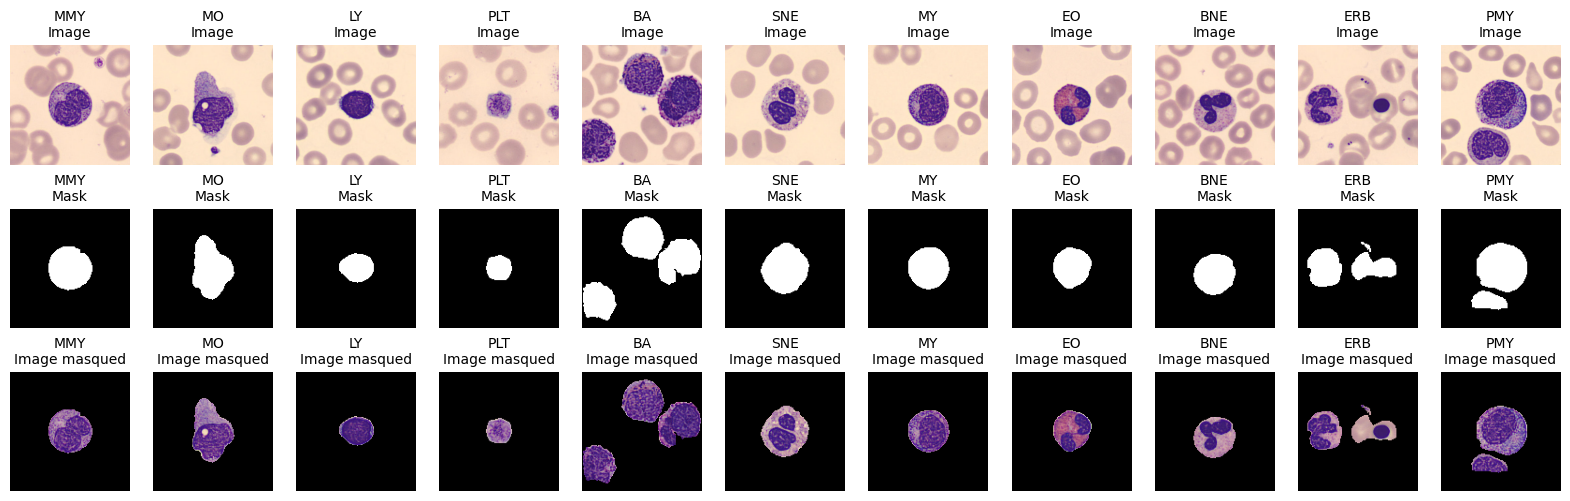

In [10]:
mask_display(image_folder, masks_folder, masked_folder, figsize=(20, 6), fontsize=10)

### Create masks on PBC 6 classes

In [4]:
input_folder = Path('../Data/PBC_6cat')
output_folder = Path('../Data/PBC_6cat_masks')

output_folder.mkdir(exist_ok=True)

for subdir in input_folder.iterdir():
    if subdir.is_dir():
        for file in tqdm(subdir.iterdir(),  desc=f"{subdir.parts[-1]}"):
            if file.is_file() and not file.name.startswith('.'):
                mask = create_mask(str(file), UNET).numpy()
                tag = file.parts[-2]
                file_name = file.parts[-1]
                Path(output_folder/tag).mkdir(exist_ok=True)
                mask_path = Path(output_folder/tag/file_name)
                cv2.imwrite(str(mask_path), mask)

basophil: 1218it [02:05,  9.69it/s]
monocyte: 1420it [02:01, 11.65it/s]
eosinophil: 3117it [04:27, 11.64it/s]
erythroblast: 1551it [02:15, 11.41it/s]
lymphocyte: 1214it [01:45, 11.52it/s]
platelet: 2348it [03:24, 11.50it/s]


Apply mask on PBC 6 classes

In [7]:
input_folder = Path('../Data/PBC_6cat')
masks_folder = Path('../Data/PBC_6cat_masks')
output_folder = Path('../Data/PBC_6cat_masked')

output_folder.mkdir(exist_ok=True)

for image_dir in input_folder.iterdir():
    if image_dir.is_dir() :
        for image_path in tqdm(image_dir.iterdir(), desc=f"{image_dir.parts[-1]}"):
            if image_path.is_file() and not image_path.name.startswith('.'):
                tag = image_path.parts[-2]
                file_name = image_path.parts[-1]
                mask_path = Path(masks_folder/tag/file_name)
                masked = apply_mask(str(image_path), str(mask_path))
                Path(output_folder/tag).mkdir(exist_ok=True)
                masked_path = Path(output_folder/tag/file_name)
                cv2.imwrite(str(masked_path), masked)

basophil: 1218it [00:07, 166.75it/s]
monocyte: 1420it [00:08, 167.76it/s]
eosinophil: 3117it [00:18, 172.06it/s]
erythroblast: 1551it [00:07, 200.61it/s]
lymphocyte: 1214it [00:05, 207.20it/s]
platelet: 2348it [00:09, 239.10it/s]


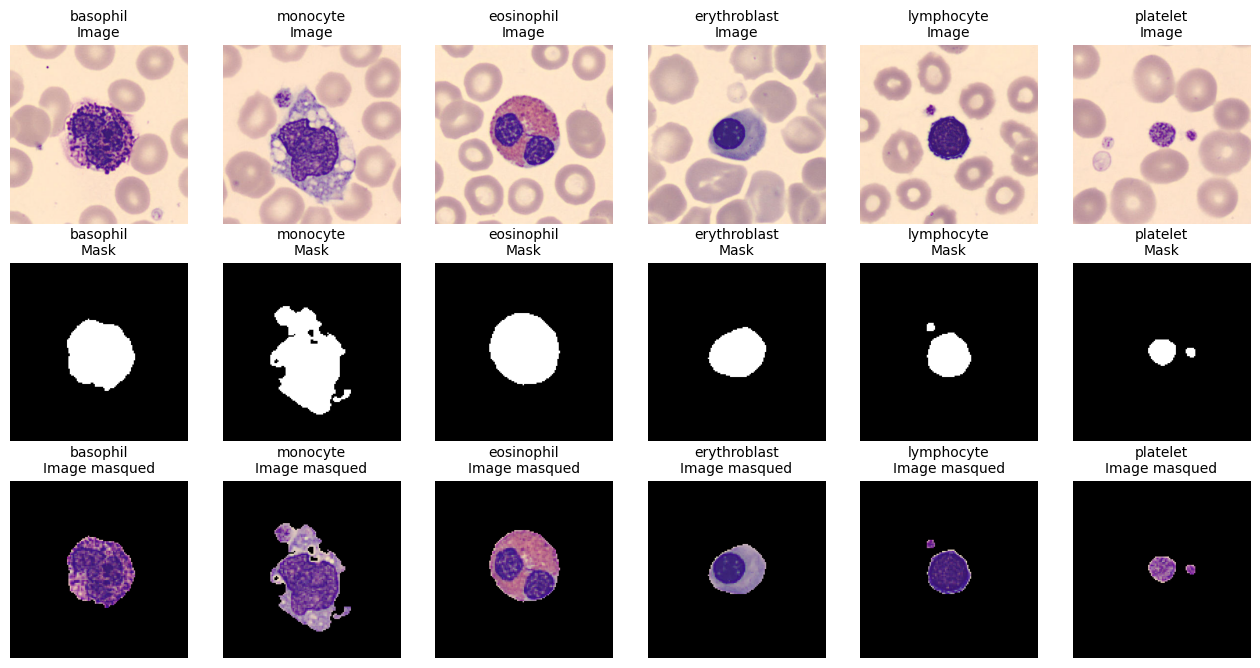

In [10]:
image_folder = Path('../Data/PBC_6cat')
masks_folder = Path('../Data/PBC_6cat_masks')
masked_folder = Path('../Data/PBC_6cat_masked')

def mask_display(image_folder, masks_folder, masked_folder, figsize=(20, 6), fontsize=10):

    Cells = [d.parts[-1] for d in image_folder.glob('*') if d.is_dir()]

    fig, axs = plt.subplots(3, len(Cells), figsize=figsize)

    for j, cell_type in enumerate(Cells):
        image = random.choice([i.parts[-1] for i in Path(image_folder/cell_type).glob('*.png') if i.is_file()])
        image_path = Path(image_folder/cell_type/image)
        mask_path = Path(masks_folder/cell_type/image)
        masked_path = Path(masked_folder/cell_type/image)
        paths = [image_path, mask_path, masked_path]
        path_types = ["Image", "Mask", "Image masqued"]

        for i, path in enumerate(paths):
            img = plt.imread(paths[i], format='png')
            if path_types[i] == "Mask":
                axs[i][j].imshow(img, cmap='gray')
            else:
                axs[i][j].imshow(img)
            axs[i][j].set_title(f"{cell_type}\n{path_types[i]}", {'fontsize' : fontsize})
            axs[i][j].set_axis_off()
    plt.show()

mask_display(image_folder, masks_folder, masked_folder, figsize=(16, 8), fontsize=10)

## Masking APL dataset

In [17]:
input_folder = Path('../Data/APL_13cat')
output_folder = Path('../Data/APL_13cat_masks')

output_folder.mkdir(exist_ok=True)

for subdir in input_folder.iterdir():
    if subdir.is_dir():
        for file in tqdm(subdir.iterdir(),  desc=f"{subdir.parts[-1]}"):
            if file.is_file() and not file.name.startswith('.'):
                mask = create_mask(str(file), UNET).numpy()
                tag = file.parts[-2]
                file_name = file.parts[-1]
                Path(output_folder/tag).mkdir(exist_ok=True)
                mask_path = Path(output_folder/tag/file_name)
                cv2.imwrite(str(mask_path), mask)


MMY: 75it [00:07,  9.82it/s]
SMU: 2930it [04:29, 10.89it/s]
MO: 1313it [02:00, 10.92it/s]
LY: 3429it [05:16, 10.85it/s]
PMO: 91it [00:08, 11.13it/s]
PLT: 66it [00:06, 10.67it/s]
BA: 53it [00:05, 10.06it/s]
SNE: 2087it [03:12, 10.87it/s]
MY: 181it [00:16, 10.75it/s]
EO: 108it [00:10, 10.78it/s]
BNE: 171it [00:16, 10.67it/s]
ERB: 521it [00:47, 10.92it/s]
PMY: 666it [01:01, 10.91it/s]


In [18]:
input_folder = Path('../Data/APL_13cat')
masks_folder = Path('../Data/APL_13cat_masks')
output_folder = Path('../Data/APL_13cat_masked')

output_folder.mkdir(exist_ok=True)

for image_dir in input_folder.iterdir():
    if image_dir.is_dir():
        for image_path in tqdm(image_dir.iterdir(), desc=f"{image_dir.parts[-1]}"):
            if image_path.is_file() and not image_path.name.startswith('.'):
                tag = image_path.parts[-2]
                file_name = image_path.parts[-1]
                mask_path = Path(masks_folder/tag/file_name)
                masked = apply_mask(str(image_path), str(mask_path))
                Path(output_folder/tag).mkdir(exist_ok=True)
                masked_path = Path(output_folder/tag/file_name)
                cv2.imwrite(str(masked_path), masked)


MMY: 75it [00:00, 153.99it/s]
SMU: 2930it [00:22, 132.22it/s]
MO: 1313it [00:11, 119.16it/s]
LY: 3429it [00:20, 168.85it/s]
PMO: 91it [00:00, 171.37it/s]
PLT: 66it [00:00, 165.61it/s]
BA: 53it [00:00, 170.28it/s]
SNE: 2087it [00:11, 174.33it/s]
MY: 181it [00:01, 160.47it/s]
EO: 108it [00:00, 169.23it/s]
BNE: 171it [00:00, 173.54it/s]
ERB: 521it [00:03, 170.76it/s]
PMY: 666it [00:03, 173.25it/s]


In [8]:
image_folder = Path('../Data/APL_13cat')
masks_folder = Path('../Data/APL_13cat_masks')
masked_folder = Path('../Data/APL_13cat_masked')


def mask_display(image_folder, masks_folder, masked_folder, figsize=(20, 6), fontsize=10):

    Cells = [d.parts[-1] for d in image_folder.glob('*') if d.is_dir()]

    fig, axs = plt.subplots(3, len(Cells), figsize=figsize)

    for j, cell_type in enumerate(Cells):
        image = random.choice(
            [i.parts[-1] for i in Path(image_folder/cell_type).glob('*.png') if i.is_file()])
        image_path = Path(image_folder/cell_type/image)
        mask_path = Path(masks_folder/cell_type/image)
        masked_path = Path(masked_folder/cell_type/image)
        paths = [image_path, mask_path, masked_path]
        path_types = ["Image", "Mask", "Image masqued"]

        for i, path in enumerate(paths):
            img = plt.imread(paths[i], format='png')
            if path_types[i] == "Mask":
                axs[i][j].imshow(img, cmap='gray')
            else:
                axs[i][j].imshow(img)
            axs[i][j].set_title(f"{cell_type}\n{path_types[i]}", {
                                'fontsize': fontsize})
            axs[i][j].set_axis_off()
    plt.show()


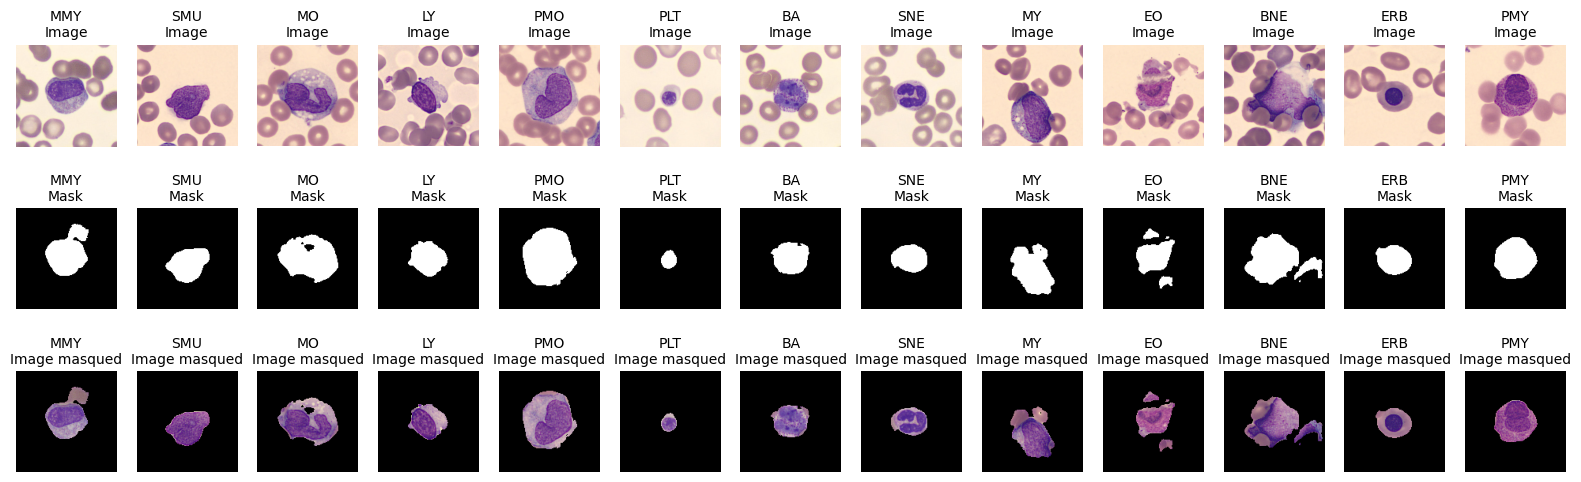

In [22]:
mask_display(image_folder, masks_folder, masked_folder,
             figsize=(20, 6), fontsize=10)


## Masking Munich dataset

In [5]:
input_folder = Path('/Volumes/Data1/Projets/Blood_cells/Data/Munich_11cat')
output_folder = Path(
    '/Volumes/Data1/Projets/Blood_cells/Data/Munich_11cat_masks')

output_folder.mkdir(exist_ok=True)

for subdir in input_folder.iterdir():
    if subdir.is_dir():
        for file in tqdm(subdir.iterdir(),  desc=f"{subdir.parts[-1]}"):
            if file.is_file() and not file.name.startswith('.'):
                mask = create_mask(str(file), UNET).numpy()
                tag = file.parts[-2]
                file_name = file.parts[-1]
                Path(output_folder/tag).mkdir(exist_ok=True)
                mask_path = Path(output_folder/tag/file_name)
                cv2.imwrite(str(mask_path), mask)


MMY: 0it [00:00, ?it/s]2023-06-11 15:59:06.978080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
MMY: 15it [00:04,  3.14it/s]
MYO: 3268it [04:54, 11.09it/s]
SMU: 15it [00:01,  9.18it/s]
MO: 1789it [02:43, 10.92it/s]
LY: 3937it [06:05, 10.77it/s]
BA: 79it [00:07, 10.81it/s]
SNE: 8484it [14:47,  9.56it/s]
EO: 424it [00:37, 11.40it/s]
BNE: 109it [00:10, 10.63it/s]
ERB: 78it [00:07, 10.17it/s]
PMY: 26it [00:02, 10.87it/s]


In [ ]:
input_folder = Path('/Volumes/Data1/Projets/Blood_cells/Data/Munich_11cat')
masks_folder = Path(
    '/Volumes/Data1/Projets/Blood_cells/Data/Munich_11cat_masks')
output_folder = Path(
    '/Volumes/Data1/Projets/Blood_cells/Data/Munich_11cat_masked')

output_folder.mkdir(exist_ok=True)

for image_dir in input_folder.iterdir():
    if image_dir.is_dir():
        for image_path in tqdm(image_dir.iterdir(), desc=f"{image_dir.parts[-1]}"):
            if image_path.is_file() and not image_path.name.startswith('.'):
                tag = image_path.parts[-2]
                file_name = image_path.parts[-1]
                mask_path = Path(masks_folder/tag/file_name)
                masked = apply_mask(str(image_path), str(mask_path))
                Path(output_folder/tag).mkdir(exist_ok=True)
                masked_path = Path(output_folder/tag/file_name)
                cv2.imwrite(str(masked_path), masked)


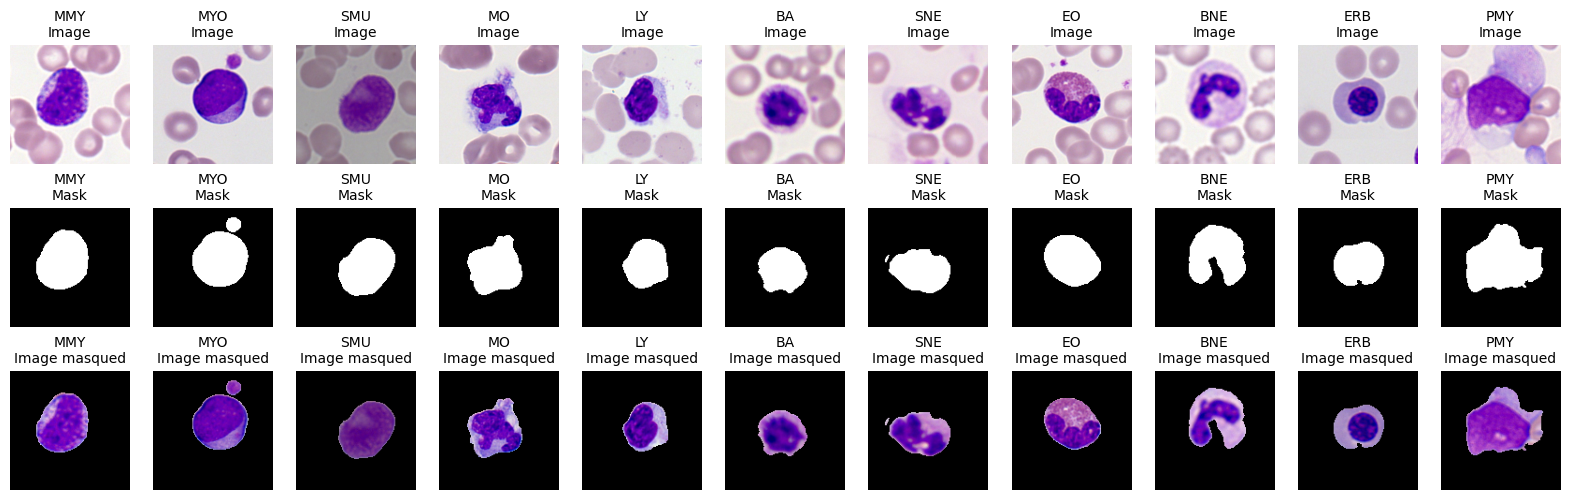

In [9]:
image_folder = Path('/Volumes/Data1/Projets/Blood_cells/Data/Munich_11cat')
masks_folder = Path(
    '/Volumes/Data1/Projets/Blood_cells/Data/Munich_11cat_masks')
masked_folder = Path(
    '/Volumes/Data1/Projets/Blood_cells/Data/Munich_11cat_masked')

mask_display(image_folder, masks_folder, masked_folder,
             figsize=(20, 6), fontsize=10)
